# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

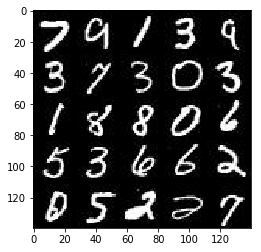

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

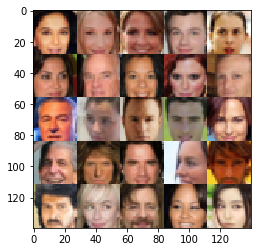

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_fake = tf.placeholder(tf.float32, (None, z_dim), name='input_fake')
    lr = tf.placeholder(tf.float32)

    return input_real, input_fake, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [73]:

def lrelu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

def batch_norm(x, training = True):
    return tf.layers.batch_normalization(x, training = training)

def conv2d(x, filters, kernel_s = 5, strides = 2, padding='same'):
    return tf.layers.conv2d(x, filters, kernel_s, strides, padding)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input: 28x28x3
        # 14x14x64
        x = lrelu(conv2d(images, 64))
        
        # 7x7x128
        x = lrelu(batch_norm(conv2d(x, 128)))       
       
        # 2x2x256 
        x = lrelu(batch_norm(conv2d(x, 256, padding = 'valid')))

        # Flatten and gen logits
        logits = tf.layers.dense( tf.reshape(x, (-1, 2*2*256)) , 1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [74]:
# Need to have methods declared again, possibly it is because of variable naming scope issues
def conv2d_t(x, filters, kernel_s = 5, strides = 2, padding='same'):
    return tf.layers.conv2d_transpose(x, filters, kernel_s, strides, padding)

def lrelu_2(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

def batch_norm_2(x, is_train = True):
    return tf.layers.batch_normalization(x, training = is_train)

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train):
        # Fully connected
        x = tf.layers.dense(z, 2*2*512)
        x = tf.reshape(x, [-1, 2, 2, 512])
      
        x = lrelu_2(batch_norm_2(x, is_train))
                          
        # 7x7x256
        x = conv2d_t(x, 256, padding = 'valid')
        x = lrelu_2(batch_norm_2(x, is_train))  
        
        # 14x14x128 
        x = lrelu_2(batch_norm_2(conv2d_t(x, 128), is_train))
       
        # Output
        # 28x28x3 or 1 
        logits = conv2d_t(x, out_channel_dim)
        return tf.tanh(logits) 
 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [75]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)                                               
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [54]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [94]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 1
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0

                # z noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    print("After run count", steps)
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.0176... Generator Loss: 1.0186
Epoch 0/2... Discriminator Loss: 0.2088... Generator Loss: 2.0640
Epoch 0/2... Discriminator Loss: 0.2237... Generator Loss: 2.8210
Epoch 0/2... Discriminator Loss: 0.7335... Generator Loss: 1.4049
Epoch 0/2... Discriminator Loss: 0.3647... Generator Loss: 1.5930
Epoch 0/2... Discriminator Loss: 1.0139... Generator Loss: 1.2439
Epoch 0/2... Discriminator Loss: 1.5986... Generator Loss: 0.5613
Epoch 0/2... Discriminator Loss: 0.8523... Generator Loss: 1.2545
Epoch 0/2... Discriminator Loss: 0.6114... Generator Loss: 1.3267
Epoch 0/2... Discriminator Loss: 0.9846... Generator Loss: 0.7230
After run count 100


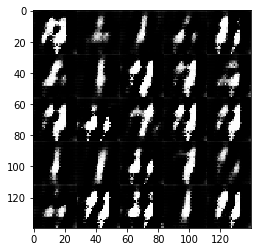

Epoch 0/2... Discriminator Loss: 0.3135... Generator Loss: 2.8646
Epoch 0/2... Discriminator Loss: 0.5098... Generator Loss: 2.1970
Epoch 0/2... Discriminator Loss: 0.6517... Generator Loss: 1.3708
Epoch 0/2... Discriminator Loss: 0.5359... Generator Loss: 1.3548
Epoch 0/2... Discriminator Loss: 0.6925... Generator Loss: 1.6373
Epoch 0/2... Discriminator Loss: 0.7975... Generator Loss: 2.1323
Epoch 0/2... Discriminator Loss: 0.4973... Generator Loss: 1.7605
Epoch 0/2... Discriminator Loss: 1.2605... Generator Loss: 0.4383
Epoch 0/2... Discriminator Loss: 0.5325... Generator Loss: 1.4912
Epoch 0/2... Discriminator Loss: 0.7359... Generator Loss: 1.8339
After run count 200


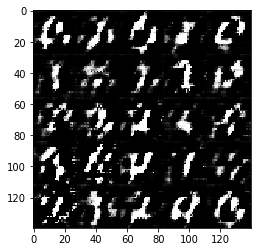

Epoch 0/2... Discriminator Loss: 1.0147... Generator Loss: 3.0588
Epoch 0/2... Discriminator Loss: 0.8690... Generator Loss: 1.0169
Epoch 0/2... Discriminator Loss: 0.6529... Generator Loss: 1.3579
Epoch 0/2... Discriminator Loss: 1.1227... Generator Loss: 0.8494
Epoch 0/2... Discriminator Loss: 0.3999... Generator Loss: 2.0209
Epoch 0/2... Discriminator Loss: 0.4656... Generator Loss: 2.0491
Epoch 0/2... Discriminator Loss: 0.9859... Generator Loss: 0.8941
Epoch 0/2... Discriminator Loss: 1.0936... Generator Loss: 0.7539
Epoch 0/2... Discriminator Loss: 0.8055... Generator Loss: 1.2436
Epoch 0/2... Discriminator Loss: 0.9545... Generator Loss: 0.9467
After run count 300


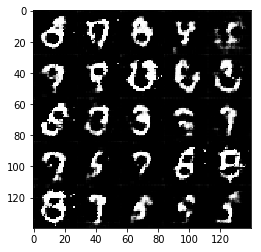

Epoch 0/2... Discriminator Loss: 1.0171... Generator Loss: 1.4576
Epoch 0/2... Discriminator Loss: 0.8372... Generator Loss: 1.3065
Epoch 0/2... Discriminator Loss: 0.9984... Generator Loss: 1.6533
Epoch 0/2... Discriminator Loss: 0.9813... Generator Loss: 1.4587
Epoch 0/2... Discriminator Loss: 1.2639... Generator Loss: 0.5585
Epoch 0/2... Discriminator Loss: 1.0998... Generator Loss: 2.7029
Epoch 0/2... Discriminator Loss: 0.8264... Generator Loss: 1.2087
Epoch 0/2... Discriminator Loss: 1.0056... Generator Loss: 0.8049
Epoch 0/2... Discriminator Loss: 1.3639... Generator Loss: 3.4825
Epoch 0/2... Discriminator Loss: 1.1671... Generator Loss: 1.6798
After run count 400


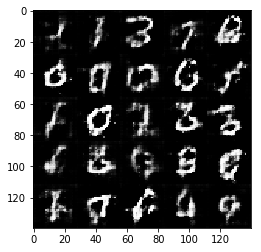

Epoch 0/2... Discriminator Loss: 0.8893... Generator Loss: 1.6628
Epoch 0/2... Discriminator Loss: 0.9954... Generator Loss: 2.6725
Epoch 0/2... Discriminator Loss: 0.9068... Generator Loss: 0.8821
Epoch 0/2... Discriminator Loss: 0.9143... Generator Loss: 1.1390
Epoch 0/2... Discriminator Loss: 0.9759... Generator Loss: 0.7647
Epoch 0/2... Discriminator Loss: 1.0465... Generator Loss: 0.7701
Epoch 0/2... Discriminator Loss: 0.8094... Generator Loss: 1.2376
Epoch 0/2... Discriminator Loss: 1.1570... Generator Loss: 2.0127
Epoch 0/2... Discriminator Loss: 1.3036... Generator Loss: 0.5157
Epoch 0/2... Discriminator Loss: 1.0232... Generator Loss: 0.7310
After run count 500


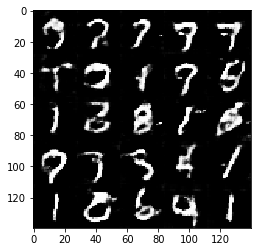

Epoch 0/2... Discriminator Loss: 0.7796... Generator Loss: 1.2630
Epoch 0/2... Discriminator Loss: 0.8284... Generator Loss: 0.8756
Epoch 0/2... Discriminator Loss: 1.0346... Generator Loss: 0.6393
Epoch 0/2... Discriminator Loss: 1.0087... Generator Loss: 0.7635
Epoch 0/2... Discriminator Loss: 1.1015... Generator Loss: 0.8042
Epoch 0/2... Discriminator Loss: 0.9186... Generator Loss: 1.3917
Epoch 0/2... Discriminator Loss: 1.0963... Generator Loss: 1.9051
Epoch 0/2... Discriminator Loss: 1.0180... Generator Loss: 0.7460
Epoch 0/2... Discriminator Loss: 1.2570... Generator Loss: 0.8249
Epoch 0/2... Discriminator Loss: 0.8168... Generator Loss: 0.8711
After run count 600


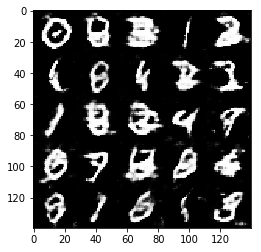

Epoch 0/2... Discriminator Loss: 1.1881... Generator Loss: 0.5974
Epoch 0/2... Discriminator Loss: 0.7863... Generator Loss: 1.1840
Epoch 0/2... Discriminator Loss: 1.2117... Generator Loss: 0.5571
Epoch 0/2... Discriminator Loss: 0.7782... Generator Loss: 1.0455
Epoch 0/2... Discriminator Loss: 1.8623... Generator Loss: 2.7284
Epoch 0/2... Discriminator Loss: 1.0155... Generator Loss: 0.9187
Epoch 0/2... Discriminator Loss: 0.9544... Generator Loss: 0.9298
Epoch 0/2... Discriminator Loss: 0.8682... Generator Loss: 1.3176
Epoch 0/2... Discriminator Loss: 1.8574... Generator Loss: 0.2357
Epoch 0/2... Discriminator Loss: 0.9781... Generator Loss: 1.1500
After run count 700


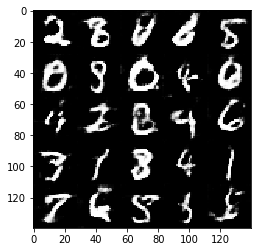

Epoch 0/2... Discriminator Loss: 1.2770... Generator Loss: 0.4986
Epoch 0/2... Discriminator Loss: 0.9066... Generator Loss: 1.0250
Epoch 0/2... Discriminator Loss: 0.9194... Generator Loss: 1.3048
Epoch 0/2... Discriminator Loss: 0.9548... Generator Loss: 0.8049
Epoch 0/2... Discriminator Loss: 2.4568... Generator Loss: 0.1461
Epoch 0/2... Discriminator Loss: 1.1000... Generator Loss: 0.6614
Epoch 0/2... Discriminator Loss: 0.9802... Generator Loss: 0.8536
Epoch 0/2... Discriminator Loss: 1.6064... Generator Loss: 2.4229
Epoch 0/2... Discriminator Loss: 1.0472... Generator Loss: 1.2622
Epoch 0/2... Discriminator Loss: 0.8324... Generator Loss: 0.9203
After run count 800


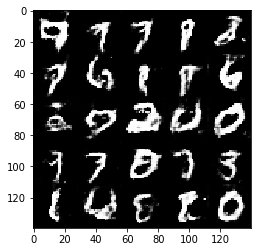

Epoch 0/2... Discriminator Loss: 1.4653... Generator Loss: 0.4500
Epoch 0/2... Discriminator Loss: 1.0392... Generator Loss: 0.7195
Epoch 0/2... Discriminator Loss: 0.8841... Generator Loss: 1.0815
Epoch 0/2... Discriminator Loss: 1.1585... Generator Loss: 1.0039
Epoch 0/2... Discriminator Loss: 1.1786... Generator Loss: 0.6168
Epoch 0/2... Discriminator Loss: 1.1015... Generator Loss: 2.1313
Epoch 0/2... Discriminator Loss: 0.9160... Generator Loss: 0.7781
Epoch 0/2... Discriminator Loss: 2.0065... Generator Loss: 3.1677
Epoch 0/2... Discriminator Loss: 1.2313... Generator Loss: 0.4879
Epoch 0/2... Discriminator Loss: 0.9386... Generator Loss: 1.0033
After run count 900


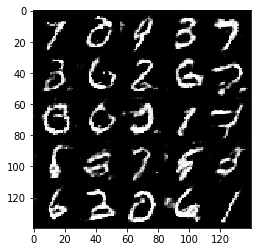

Epoch 0/2... Discriminator Loss: 1.4622... Generator Loss: 0.3774
Epoch 0/2... Discriminator Loss: 0.6360... Generator Loss: 1.5383
Epoch 0/2... Discriminator Loss: 1.5781... Generator Loss: 2.7637
Epoch 1/2... Discriminator Loss: 1.0328... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 0.9554... Generator Loss: 1.8720
Epoch 1/2... Discriminator Loss: 1.9583... Generator Loss: 0.2416
Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 1.6105
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 1.0598
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 0.8060... Generator Loss: 1.0556
After run count 1000


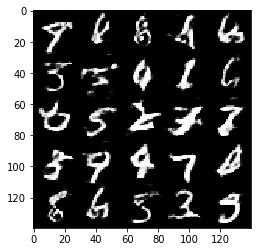

Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.5476
Epoch 1/2... Discriminator Loss: 1.1943... Generator Loss: 0.5465
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 1.6213
Epoch 1/2... Discriminator Loss: 0.8764... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.5127
Epoch 1/2... Discriminator Loss: 2.3497... Generator Loss: 0.1703
Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 1.2050
Epoch 1/2... Discriminator Loss: 0.7579... Generator Loss: 1.0522
After run count 1100


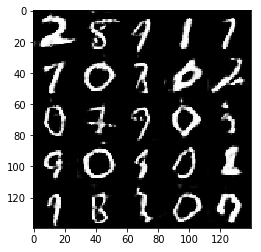

Epoch 1/2... Discriminator Loss: 2.0680... Generator Loss: 0.2343
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 0.8604
Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 0.7294
Epoch 1/2... Discriminator Loss: 2.3671... Generator Loss: 0.1621
Epoch 1/2... Discriminator Loss: 2.6740... Generator Loss: 0.1365
Epoch 1/2... Discriminator Loss: 1.7381... Generator Loss: 0.2946
Epoch 1/2... Discriminator Loss: 0.6200... Generator Loss: 1.2988
Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.4213
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 1.2811
Epoch 1/2... Discriminator Loss: 1.7052... Generator Loss: 0.4539
After run count 1200


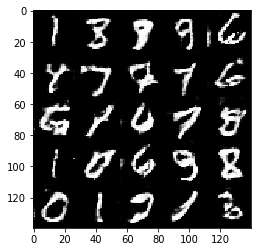

Epoch 1/2... Discriminator Loss: 1.9144... Generator Loss: 0.2485
Epoch 1/2... Discriminator Loss: 0.6668... Generator Loss: 1.6091
Epoch 1/2... Discriminator Loss: 0.5632... Generator Loss: 1.4340
Epoch 1/2... Discriminator Loss: 0.9146... Generator Loss: 1.8554
Epoch 1/2... Discriminator Loss: 0.7901... Generator Loss: 1.2808
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 1.6115
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 1.1589
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.7863
Epoch 1/2... Discriminator Loss: 0.7775... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 0.7128
After run count 1300


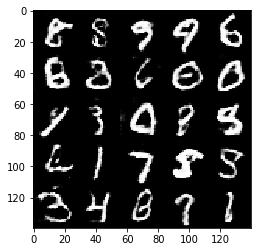

Epoch 1/2... Discriminator Loss: 0.7004... Generator Loss: 2.0564
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 0.9670
Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.4471
Epoch 1/2... Discriminator Loss: 0.9023... Generator Loss: 1.7618
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.1170
Epoch 1/2... Discriminator Loss: 2.3511... Generator Loss: 0.2490
Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 0.8504
Epoch 1/2... Discriminator Loss: 0.6561... Generator Loss: 1.2345
Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 3.4318
After run count 1400


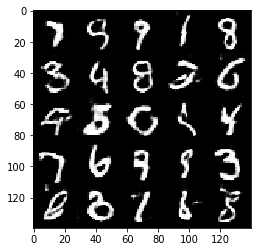

Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.4461
Epoch 1/2... Discriminator Loss: 0.7868... Generator Loss: 1.2486
Epoch 1/2... Discriminator Loss: 0.8023... Generator Loss: 2.0434
Epoch 1/2... Discriminator Loss: 0.8946... Generator Loss: 0.8857
Epoch 1/2... Discriminator Loss: 0.4413... Generator Loss: 1.7452
Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.1922
Epoch 1/2... Discriminator Loss: 2.7236... Generator Loss: 0.1273
Epoch 1/2... Discriminator Loss: 0.6786... Generator Loss: 1.7083
Epoch 1/2... Discriminator Loss: 1.6177... Generator Loss: 0.3766
Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 1.5773
After run count 1500


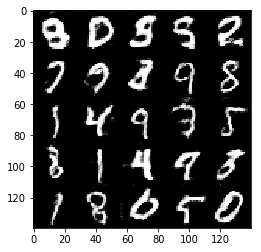

Epoch 1/2... Discriminator Loss: 0.7316... Generator Loss: 1.1217
Epoch 1/2... Discriminator Loss: 0.8542... Generator Loss: 2.2285
Epoch 1/2... Discriminator Loss: 1.7101... Generator Loss: 3.3231
Epoch 1/2... Discriminator Loss: 0.7280... Generator Loss: 1.6787
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 0.6018
Epoch 1/2... Discriminator Loss: 0.4672... Generator Loss: 1.7202
Epoch 1/2... Discriminator Loss: 0.8150... Generator Loss: 1.3866
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 2.4383
Epoch 1/2... Discriminator Loss: 1.7772... Generator Loss: 0.3530
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.5152
After run count 1600


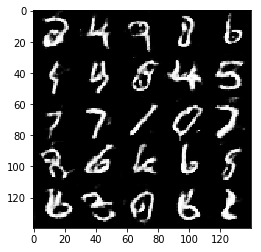

Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 0.4968
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 1.7647... Generator Loss: 0.4081
Epoch 1/2... Discriminator Loss: 0.7982... Generator Loss: 1.5406
Epoch 1/2... Discriminator Loss: 0.5529... Generator Loss: 1.6197
Epoch 1/2... Discriminator Loss: 0.6798... Generator Loss: 1.5856
Epoch 1/2... Discriminator Loss: 0.5747... Generator Loss: 1.2970
Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 0.5737
Epoch 1/2... Discriminator Loss: 0.8574... Generator Loss: 1.3338
Epoch 1/2... Discriminator Loss: 0.4519... Generator Loss: 1.6474
After run count 1700


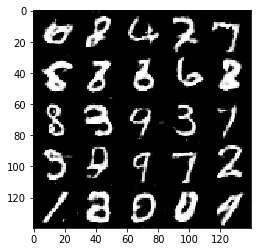

Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 0.5758... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 3.3343... Generator Loss: 0.1349
Epoch 1/2... Discriminator Loss: 0.7767... Generator Loss: 1.1512
Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 0.7838... Generator Loss: 1.0896
Epoch 1/2... Discriminator Loss: 0.9999... Generator Loss: 0.9296
Epoch 1/2... Discriminator Loss: 0.8763... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 0.8317... Generator Loss: 1.0163
After run count 1800


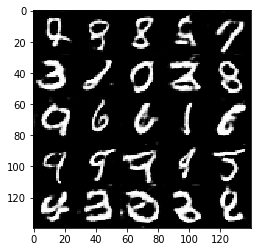

Epoch 1/2... Discriminator Loss: 0.6388... Generator Loss: 1.1598
Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.5221
Epoch 1/2... Discriminator Loss: 0.6886... Generator Loss: 1.2532
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 0.5172... Generator Loss: 1.9602
Epoch 1/2... Discriminator Loss: 1.1219... Generator Loss: 0.6299


In [95]:
batch_size = 64
z_dim = 100
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.5038... Generator Loss: 6.3264
Epoch 0/1... Discriminator Loss: 0.0664... Generator Loss: 5.3152
Epoch 0/1... Discriminator Loss: 1.8493... Generator Loss: 0.1957
Epoch 0/1... Discriminator Loss: 1.2909... Generator Loss: 0.3651
Epoch 0/1... Discriminator Loss: 0.1451... Generator Loss: 2.4316
Epoch 0/1... Discriminator Loss: 0.8717... Generator Loss: 0.5720
Epoch 0/1... Discriminator Loss: 0.2201... Generator Loss: 2.1374
Epoch 0/1... Discriminator Loss: 0.7047... Generator Loss: 0.7783
Epoch 0/1... Discriminator Loss: 0.3412... Generator Loss: 3.6014
Epoch 0/1... Discriminator Loss: 0.5647... Generator Loss: 2.8576
After run count 100


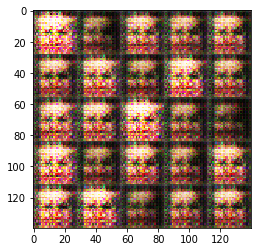

Epoch 0/1... Discriminator Loss: 0.4531... Generator Loss: 1.1952
Epoch 0/1... Discriminator Loss: 0.9030... Generator Loss: 5.0197
Epoch 0/1... Discriminator Loss: 0.5083... Generator Loss: 1.7993
Epoch 0/1... Discriminator Loss: 1.3238... Generator Loss: 6.9449
Epoch 0/1... Discriminator Loss: 0.7406... Generator Loss: 1.4073
Epoch 0/1... Discriminator Loss: 0.7857... Generator Loss: 2.7106
Epoch 0/1... Discriminator Loss: 0.6069... Generator Loss: 1.5359
Epoch 0/1... Discriminator Loss: 0.7929... Generator Loss: 0.9431
Epoch 0/1... Discriminator Loss: 0.9927... Generator Loss: 2.0172
Epoch 0/1... Discriminator Loss: 1.1623... Generator Loss: 1.9840
After run count 200


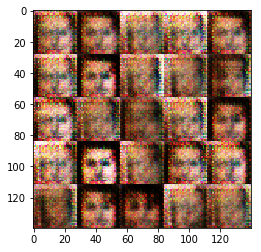

Epoch 0/1... Discriminator Loss: 1.0149... Generator Loss: 1.4760
Epoch 0/1... Discriminator Loss: 0.9547... Generator Loss: 1.0221
Epoch 0/1... Discriminator Loss: 0.7489... Generator Loss: 1.1810
Epoch 0/1... Discriminator Loss: 1.3668... Generator Loss: 0.5657
Epoch 0/1... Discriminator Loss: 0.9928... Generator Loss: 0.9288
Epoch 0/1... Discriminator Loss: 1.5549... Generator Loss: 2.6088
Epoch 0/1... Discriminator Loss: 1.1322... Generator Loss: 0.8546
Epoch 0/1... Discriminator Loss: 0.9966... Generator Loss: 0.8651
Epoch 0/1... Discriminator Loss: 1.2603... Generator Loss: 0.8556
Epoch 0/1... Discriminator Loss: 0.9995... Generator Loss: 0.9788
After run count 300


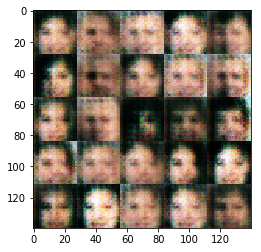

Epoch 0/1... Discriminator Loss: 1.3347... Generator Loss: 0.7726
Epoch 0/1... Discriminator Loss: 0.9260... Generator Loss: 0.9159
Epoch 0/1... Discriminator Loss: 1.0792... Generator Loss: 0.9162
Epoch 0/1... Discriminator Loss: 1.5618... Generator Loss: 0.7888
Epoch 0/1... Discriminator Loss: 1.0770... Generator Loss: 1.0826
Epoch 0/1... Discriminator Loss: 1.2389... Generator Loss: 0.9552
Epoch 0/1... Discriminator Loss: 1.1739... Generator Loss: 1.2048
Epoch 0/1... Discriminator Loss: 0.9746... Generator Loss: 0.8411
Epoch 0/1... Discriminator Loss: 1.1561... Generator Loss: 0.9201
Epoch 0/1... Discriminator Loss: 1.4133... Generator Loss: 0.5563
After run count 400


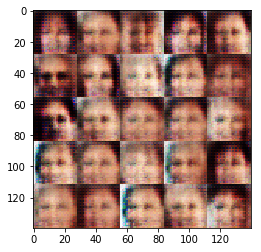

Epoch 0/1... Discriminator Loss: 1.0615... Generator Loss: 0.7249
Epoch 0/1... Discriminator Loss: 1.2876... Generator Loss: 1.0841
Epoch 0/1... Discriminator Loss: 1.1786... Generator Loss: 0.9850
Epoch 0/1... Discriminator Loss: 1.5581... Generator Loss: 1.5290
Epoch 0/1... Discriminator Loss: 1.1651... Generator Loss: 0.6619
Epoch 0/1... Discriminator Loss: 0.8601... Generator Loss: 1.1867
Epoch 0/1... Discriminator Loss: 1.1110... Generator Loss: 1.1017
Epoch 0/1... Discriminator Loss: 0.7036... Generator Loss: 1.2577
Epoch 0/1... Discriminator Loss: 0.8548... Generator Loss: 1.0236
Epoch 0/1... Discriminator Loss: 1.0238... Generator Loss: 1.0217
After run count 500


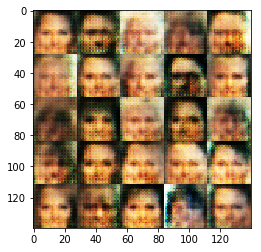

Epoch 0/1... Discriminator Loss: 1.2844... Generator Loss: 1.0655
Epoch 0/1... Discriminator Loss: 1.0863... Generator Loss: 0.9492
Epoch 0/1... Discriminator Loss: 0.7764... Generator Loss: 1.2334
Epoch 0/1... Discriminator Loss: 1.3814... Generator Loss: 0.8048
Epoch 0/1... Discriminator Loss: 1.1244... Generator Loss: 0.6603
Epoch 0/1... Discriminator Loss: 0.9762... Generator Loss: 0.7796
Epoch 0/1... Discriminator Loss: 1.1225... Generator Loss: 0.9174
Epoch 0/1... Discriminator Loss: 1.0307... Generator Loss: 1.1224
Epoch 0/1... Discriminator Loss: 1.1263... Generator Loss: 0.7145
Epoch 0/1... Discriminator Loss: 1.0610... Generator Loss: 1.1680
After run count 600


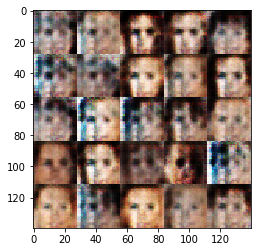

Epoch 0/1... Discriminator Loss: 0.8565... Generator Loss: 1.2999
Epoch 0/1... Discriminator Loss: 1.0217... Generator Loss: 1.1135
Epoch 0/1... Discriminator Loss: 1.1625... Generator Loss: 0.8754
Epoch 0/1... Discriminator Loss: 0.8702... Generator Loss: 1.3426
Epoch 0/1... Discriminator Loss: 1.2633... Generator Loss: 0.8869
Epoch 0/1... Discriminator Loss: 0.7835... Generator Loss: 1.3586
Epoch 0/1... Discriminator Loss: 1.2809... Generator Loss: 0.7798
Epoch 0/1... Discriminator Loss: 0.8951... Generator Loss: 1.1052
Epoch 0/1... Discriminator Loss: 0.8408... Generator Loss: 1.2498
Epoch 0/1... Discriminator Loss: 0.9703... Generator Loss: 1.3173
After run count 700


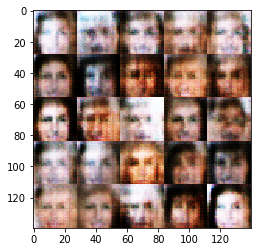

Epoch 0/1... Discriminator Loss: 0.9584... Generator Loss: 0.8592
Epoch 0/1... Discriminator Loss: 1.0912... Generator Loss: 1.1046
Epoch 0/1... Discriminator Loss: 0.9640... Generator Loss: 1.1762
Epoch 0/1... Discriminator Loss: 1.2329... Generator Loss: 0.6863
Epoch 0/1... Discriminator Loss: 1.9792... Generator Loss: 0.2056
Epoch 0/1... Discriminator Loss: 1.1067... Generator Loss: 0.8695
Epoch 0/1... Discriminator Loss: 1.2137... Generator Loss: 0.9183
Epoch 0/1... Discriminator Loss: 1.1170... Generator Loss: 0.9352
Epoch 0/1... Discriminator Loss: 1.1949... Generator Loss: 0.8543
Epoch 0/1... Discriminator Loss: 0.8340... Generator Loss: 1.0833
After run count 800


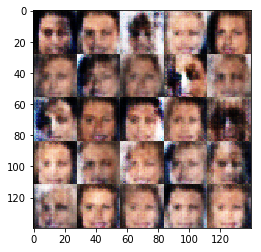

Epoch 0/1... Discriminator Loss: 1.1742... Generator Loss: 0.9643
Epoch 0/1... Discriminator Loss: 1.0428... Generator Loss: 1.0460
Epoch 0/1... Discriminator Loss: 0.9958... Generator Loss: 0.8739
Epoch 0/1... Discriminator Loss: 1.1630... Generator Loss: 0.8098
Epoch 0/1... Discriminator Loss: 1.2593... Generator Loss: 0.6386
Epoch 0/1... Discriminator Loss: 1.1071... Generator Loss: 0.6969
Epoch 0/1... Discriminator Loss: 1.3049... Generator Loss: 1.1782
Epoch 0/1... Discriminator Loss: 1.0201... Generator Loss: 0.8361
Epoch 0/1... Discriminator Loss: 1.0465... Generator Loss: 1.0722
Epoch 0/1... Discriminator Loss: 1.0930... Generator Loss: 1.4992
After run count 900


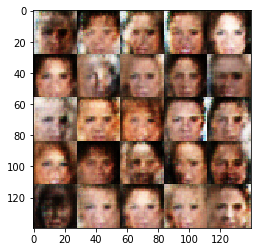

Epoch 0/1... Discriminator Loss: 0.9799... Generator Loss: 0.9734
Epoch 0/1... Discriminator Loss: 1.1211... Generator Loss: 0.6866
Epoch 0/1... Discriminator Loss: 1.0972... Generator Loss: 0.6113
Epoch 0/1... Discriminator Loss: 1.6970... Generator Loss: 2.2945
Epoch 0/1... Discriminator Loss: 1.0345... Generator Loss: 1.0688
Epoch 0/1... Discriminator Loss: 1.1358... Generator Loss: 0.8268
Epoch 0/1... Discriminator Loss: 0.8922... Generator Loss: 1.0823
Epoch 0/1... Discriminator Loss: 1.3040... Generator Loss: 0.5329
Epoch 0/1... Discriminator Loss: 1.0601... Generator Loss: 0.9506
Epoch 0/1... Discriminator Loss: 1.0063... Generator Loss: 0.8366
After run count 1000


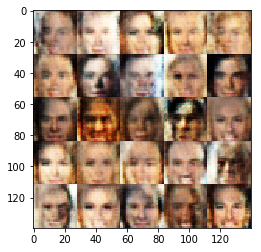

Epoch 0/1... Discriminator Loss: 1.0351... Generator Loss: 1.1731
Epoch 0/1... Discriminator Loss: 1.0442... Generator Loss: 1.0390
Epoch 0/1... Discriminator Loss: 1.1880... Generator Loss: 0.9204
Epoch 0/1... Discriminator Loss: 0.8854... Generator Loss: 1.3896
Epoch 0/1... Discriminator Loss: 1.1233... Generator Loss: 1.0216
Epoch 0/1... Discriminator Loss: 1.2494... Generator Loss: 1.1456
Epoch 0/1... Discriminator Loss: 1.1293... Generator Loss: 1.2850
Epoch 0/1... Discriminator Loss: 0.9707... Generator Loss: 1.1825
Epoch 0/1... Discriminator Loss: 1.1996... Generator Loss: 0.7092
Epoch 0/1... Discriminator Loss: 1.2385... Generator Loss: 1.1403
After run count 1100


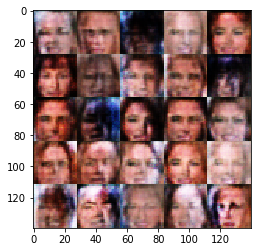

Epoch 0/1... Discriminator Loss: 1.3538... Generator Loss: 0.5632
Epoch 0/1... Discriminator Loss: 1.1046... Generator Loss: 0.7189
Epoch 0/1... Discriminator Loss: 1.2706... Generator Loss: 0.5388
Epoch 0/1... Discriminator Loss: 1.2659... Generator Loss: 0.5537
Epoch 0/1... Discriminator Loss: 1.0378... Generator Loss: 0.8630
Epoch 0/1... Discriminator Loss: 1.0164... Generator Loss: 1.1110
Epoch 0/1... Discriminator Loss: 1.1091... Generator Loss: 0.8909
Epoch 0/1... Discriminator Loss: 1.1700... Generator Loss: 1.4493
Epoch 0/1... Discriminator Loss: 1.1505... Generator Loss: 1.7577
Epoch 0/1... Discriminator Loss: 1.1138... Generator Loss: 1.0401
After run count 1200


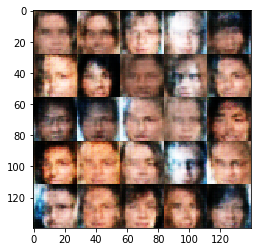

Epoch 0/1... Discriminator Loss: 1.1971... Generator Loss: 0.6126
Epoch 0/1... Discriminator Loss: 0.9745... Generator Loss: 1.0134
Epoch 0/1... Discriminator Loss: 0.9640... Generator Loss: 0.9921
Epoch 0/1... Discriminator Loss: 0.8930... Generator Loss: 1.0528
Epoch 0/1... Discriminator Loss: 1.0964... Generator Loss: 1.1924
Epoch 0/1... Discriminator Loss: 0.9768... Generator Loss: 0.8206
Epoch 0/1... Discriminator Loss: 1.0394... Generator Loss: 1.0250
Epoch 0/1... Discriminator Loss: 1.1023... Generator Loss: 0.6835
Epoch 0/1... Discriminator Loss: 1.3799... Generator Loss: 0.6172
Epoch 0/1... Discriminator Loss: 1.1390... Generator Loss: 0.7559
After run count 1300


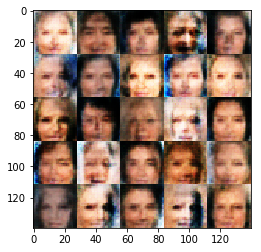

Epoch 0/1... Discriminator Loss: 1.1408... Generator Loss: 0.7719
Epoch 0/1... Discriminator Loss: 1.1697... Generator Loss: 0.8308
Epoch 0/1... Discriminator Loss: 1.5728... Generator Loss: 0.4602
Epoch 0/1... Discriminator Loss: 0.9536... Generator Loss: 1.4118
Epoch 0/1... Discriminator Loss: 0.9156... Generator Loss: 1.1036
Epoch 0/1... Discriminator Loss: 1.0344... Generator Loss: 1.0488
Epoch 0/1... Discriminator Loss: 1.2231... Generator Loss: 0.7497
Epoch 0/1... Discriminator Loss: 1.1621... Generator Loss: 0.6891
Epoch 0/1... Discriminator Loss: 1.4156... Generator Loss: 0.4870
Epoch 0/1... Discriminator Loss: 0.9685... Generator Loss: 1.0889
After run count 1400


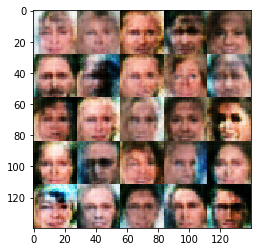

Epoch 0/1... Discriminator Loss: 0.9116... Generator Loss: 1.1061
Epoch 0/1... Discriminator Loss: 0.9879... Generator Loss: 1.5417
Epoch 0/1... Discriminator Loss: 1.3992... Generator Loss: 1.7468
Epoch 0/1... Discriminator Loss: 1.3142... Generator Loss: 0.5105
Epoch 0/1... Discriminator Loss: 1.0165... Generator Loss: 1.0463
Epoch 0/1... Discriminator Loss: 0.7452... Generator Loss: 1.4636
Epoch 0/1... Discriminator Loss: 0.9944... Generator Loss: 1.2421
Epoch 0/1... Discriminator Loss: 1.1156... Generator Loss: 0.8880
Epoch 0/1... Discriminator Loss: 1.1004... Generator Loss: 1.2836
Epoch 0/1... Discriminator Loss: 0.8675... Generator Loss: 1.1210
After run count 1500


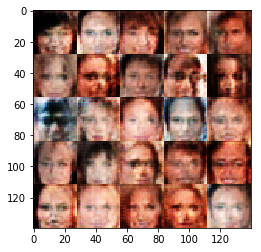

Epoch 0/1... Discriminator Loss: 1.0531... Generator Loss: 0.9142
Epoch 0/1... Discriminator Loss: 0.9030... Generator Loss: 1.2636
Epoch 0/1... Discriminator Loss: 1.4428... Generator Loss: 1.9756
Epoch 0/1... Discriminator Loss: 0.9256... Generator Loss: 1.1699
Epoch 0/1... Discriminator Loss: 1.2319... Generator Loss: 0.5128
Epoch 0/1... Discriminator Loss: 0.9827... Generator Loss: 0.7517
Epoch 0/1... Discriminator Loss: 1.3045... Generator Loss: 0.7487
Epoch 0/1... Discriminator Loss: 1.1530... Generator Loss: 0.6265
Epoch 0/1... Discriminator Loss: 1.1423... Generator Loss: 0.9954
Epoch 0/1... Discriminator Loss: 0.9516... Generator Loss: 1.0616
After run count 1600


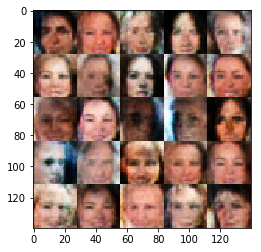

Epoch 0/1... Discriminator Loss: 1.0621... Generator Loss: 0.8515
Epoch 0/1... Discriminator Loss: 0.9554... Generator Loss: 0.9868
Epoch 0/1... Discriminator Loss: 1.0646... Generator Loss: 0.6192
Epoch 0/1... Discriminator Loss: 1.0406... Generator Loss: 1.1298
Epoch 0/1... Discriminator Loss: 1.1611... Generator Loss: 0.6656
Epoch 0/1... Discriminator Loss: 0.9177... Generator Loss: 1.9008
Epoch 0/1... Discriminator Loss: 1.0952... Generator Loss: 0.6486
Epoch 0/1... Discriminator Loss: 0.9885... Generator Loss: 0.8774
Epoch 0/1... Discriminator Loss: 0.9304... Generator Loss: 1.2139
Epoch 0/1... Discriminator Loss: 0.8254... Generator Loss: 1.3154
After run count 1700


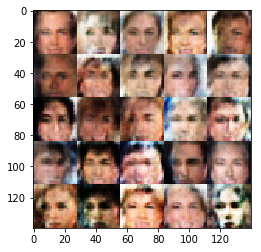

Epoch 0/1... Discriminator Loss: 1.1682... Generator Loss: 0.5922
Epoch 0/1... Discriminator Loss: 1.0635... Generator Loss: 0.7969
Epoch 0/1... Discriminator Loss: 1.1028... Generator Loss: 0.7134
Epoch 0/1... Discriminator Loss: 1.4642... Generator Loss: 1.6807
Epoch 0/1... Discriminator Loss: 1.0337... Generator Loss: 1.0612
Epoch 0/1... Discriminator Loss: 1.0445... Generator Loss: 0.7495
Epoch 0/1... Discriminator Loss: 0.9909... Generator Loss: 1.2257
Epoch 0/1... Discriminator Loss: 1.0974... Generator Loss: 0.6951
Epoch 0/1... Discriminator Loss: 1.1310... Generator Loss: 0.7271
Epoch 0/1... Discriminator Loss: 1.0568... Generator Loss: 1.1238
After run count 1800


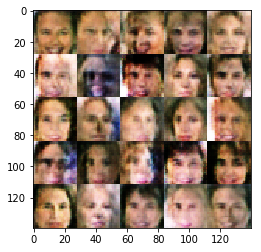

Epoch 0/1... Discriminator Loss: 0.7788... Generator Loss: 1.2770
Epoch 0/1... Discriminator Loss: 1.0426... Generator Loss: 0.6738
Epoch 0/1... Discriminator Loss: 2.0770... Generator Loss: 3.2968
Epoch 0/1... Discriminator Loss: 0.9346... Generator Loss: 0.9414
Epoch 0/1... Discriminator Loss: 1.0042... Generator Loss: 0.8754
Epoch 0/1... Discriminator Loss: 0.9514... Generator Loss: 1.2816
Epoch 0/1... Discriminator Loss: 1.1131... Generator Loss: 0.6337
Epoch 0/1... Discriminator Loss: 1.0088... Generator Loss: 1.7517
Epoch 0/1... Discriminator Loss: 1.1991... Generator Loss: 0.5804
Epoch 0/1... Discriminator Loss: 0.9018... Generator Loss: 1.0767
After run count 1900


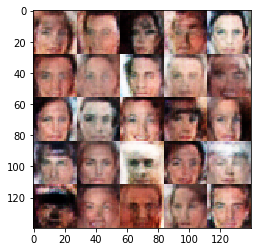

Epoch 0/1... Discriminator Loss: 0.7963... Generator Loss: 1.1148
Epoch 0/1... Discriminator Loss: 1.3645... Generator Loss: 0.4572
Epoch 0/1... Discriminator Loss: 0.8631... Generator Loss: 1.1643
Epoch 0/1... Discriminator Loss: 0.9555... Generator Loss: 0.8889
Epoch 0/1... Discriminator Loss: 1.2378... Generator Loss: 0.5555
Epoch 0/1... Discriminator Loss: 0.8933... Generator Loss: 1.0292
Epoch 0/1... Discriminator Loss: 0.7711... Generator Loss: 1.7306
Epoch 0/1... Discriminator Loss: 0.7845... Generator Loss: 1.2194
Epoch 0/1... Discriminator Loss: 0.8888... Generator Loss: 1.0774
Epoch 0/1... Discriminator Loss: 0.8811... Generator Loss: 1.2212
After run count 2000


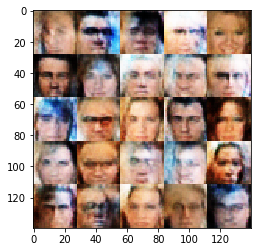

Epoch 0/1... Discriminator Loss: 1.0596... Generator Loss: 0.8287
Epoch 0/1... Discriminator Loss: 0.8177... Generator Loss: 1.1190
Epoch 0/1... Discriminator Loss: 0.9883... Generator Loss: 0.7486
Epoch 0/1... Discriminator Loss: 1.0905... Generator Loss: 0.7219
Epoch 0/1... Discriminator Loss: 0.9668... Generator Loss: 0.9101
Epoch 0/1... Discriminator Loss: 1.0599... Generator Loss: 0.9417
Epoch 0/1... Discriminator Loss: 1.0960... Generator Loss: 0.7712
Epoch 0/1... Discriminator Loss: 1.0737... Generator Loss: 0.6556
Epoch 0/1... Discriminator Loss: 1.2036... Generator Loss: 0.6433
Epoch 0/1... Discriminator Loss: 1.0030... Generator Loss: 1.0390
After run count 2100


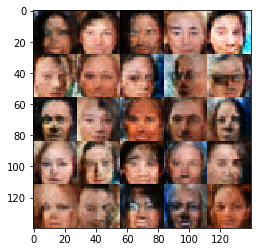

Epoch 0/1... Discriminator Loss: 0.8057... Generator Loss: 1.4908
Epoch 0/1... Discriminator Loss: 1.3471... Generator Loss: 0.4870
Epoch 0/1... Discriminator Loss: 0.9136... Generator Loss: 0.8179
Epoch 0/1... Discriminator Loss: 0.9742... Generator Loss: 1.2302
Epoch 0/1... Discriminator Loss: 0.8430... Generator Loss: 1.1035
Epoch 0/1... Discriminator Loss: 0.9722... Generator Loss: 0.9870
Epoch 0/1... Discriminator Loss: 0.9424... Generator Loss: 1.0935
Epoch 0/1... Discriminator Loss: 1.0841... Generator Loss: 0.6772
Epoch 0/1... Discriminator Loss: 1.0550... Generator Loss: 0.8257
Epoch 0/1... Discriminator Loss: 0.8597... Generator Loss: 1.0058
After run count 2200


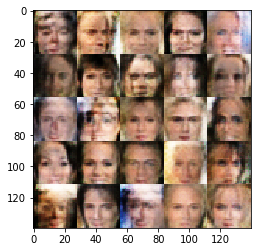

Epoch 0/1... Discriminator Loss: 1.2766... Generator Loss: 0.5169
Epoch 0/1... Discriminator Loss: 0.8174... Generator Loss: 1.2630
Epoch 0/1... Discriminator Loss: 0.8855... Generator Loss: 0.9076
Epoch 0/1... Discriminator Loss: 0.9672... Generator Loss: 0.7096
Epoch 0/1... Discriminator Loss: 0.7683... Generator Loss: 1.3370
Epoch 0/1... Discriminator Loss: 1.0727... Generator Loss: 0.7143
Epoch 0/1... Discriminator Loss: 0.9466... Generator Loss: 1.0341
Epoch 0/1... Discriminator Loss: 0.9209... Generator Loss: 0.9994
Epoch 0/1... Discriminator Loss: 0.9030... Generator Loss: 1.0595
Epoch 0/1... Discriminator Loss: 0.8035... Generator Loss: 1.5821
After run count 2300


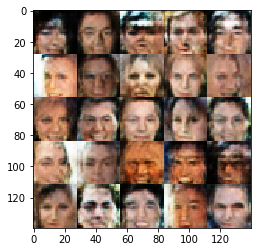

Epoch 0/1... Discriminator Loss: 0.8172... Generator Loss: 1.1468
Epoch 0/1... Discriminator Loss: 0.9063... Generator Loss: 0.9039
Epoch 0/1... Discriminator Loss: 1.0587... Generator Loss: 0.6717
Epoch 0/1... Discriminator Loss: 0.7949... Generator Loss: 1.3188
Epoch 0/1... Discriminator Loss: 0.9207... Generator Loss: 0.8466
Epoch 0/1... Discriminator Loss: 0.9481... Generator Loss: 0.8898
Epoch 0/1... Discriminator Loss: 1.1654... Generator Loss: 0.6665
Epoch 0/1... Discriminator Loss: 0.8680... Generator Loss: 1.0155
Epoch 0/1... Discriminator Loss: 0.8246... Generator Loss: 1.3230
Epoch 0/1... Discriminator Loss: 0.9969... Generator Loss: 0.9165
After run count 2400


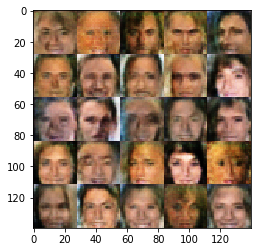

Epoch 0/1... Discriminator Loss: 0.9851... Generator Loss: 0.8026
Epoch 0/1... Discriminator Loss: 0.9685... Generator Loss: 0.9903
Epoch 0/1... Discriminator Loss: 1.0053... Generator Loss: 1.0282
Epoch 0/1... Discriminator Loss: 0.8469... Generator Loss: 1.1004
Epoch 0/1... Discriminator Loss: 0.8948... Generator Loss: 0.9993
Epoch 0/1... Discriminator Loss: 1.1646... Generator Loss: 0.7217
Epoch 0/1... Discriminator Loss: 1.0987... Generator Loss: 1.1209
Epoch 0/1... Discriminator Loss: 0.9522... Generator Loss: 1.0526
Epoch 0/1... Discriminator Loss: 1.1425... Generator Loss: 1.9303
Epoch 0/1... Discriminator Loss: 1.2265... Generator Loss: 0.6074
After run count 2500


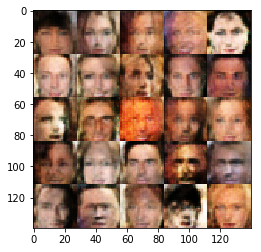

Epoch 0/1... Discriminator Loss: 0.9803... Generator Loss: 0.7312
Epoch 0/1... Discriminator Loss: 0.9027... Generator Loss: 0.8745
Epoch 0/1... Discriminator Loss: 0.9390... Generator Loss: 1.0944
Epoch 0/1... Discriminator Loss: 0.9145... Generator Loss: 1.0794
Epoch 0/1... Discriminator Loss: 0.8655... Generator Loss: 0.9098
Epoch 0/1... Discriminator Loss: 1.0039... Generator Loss: 1.0011
Epoch 0/1... Discriminator Loss: 0.9109... Generator Loss: 0.8342
Epoch 0/1... Discriminator Loss: 1.1895... Generator Loss: 0.5552
Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 1.2764
Epoch 0/1... Discriminator Loss: 0.9839... Generator Loss: 0.9327
After run count 2600


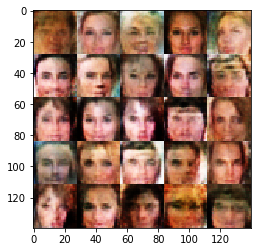

Epoch 0/1... Discriminator Loss: 0.7449... Generator Loss: 1.7091
Epoch 0/1... Discriminator Loss: 0.8699... Generator Loss: 1.1982
Epoch 0/1... Discriminator Loss: 0.8962... Generator Loss: 0.9591
Epoch 0/1... Discriminator Loss: 1.1643... Generator Loss: 0.7382
Epoch 0/1... Discriminator Loss: 1.1128... Generator Loss: 0.8308
Epoch 0/1... Discriminator Loss: 1.0544... Generator Loss: 0.7816
Epoch 0/1... Discriminator Loss: 1.2148... Generator Loss: 1.6069
Epoch 0/1... Discriminator Loss: 1.0850... Generator Loss: 0.6954
Epoch 0/1... Discriminator Loss: 0.8708... Generator Loss: 0.9872
Epoch 0/1... Discriminator Loss: 1.2268... Generator Loss: 1.4969
After run count 2700


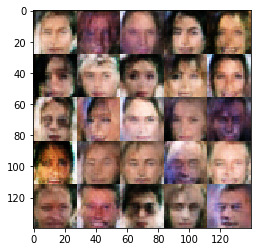

Epoch 0/1... Discriminator Loss: 0.8492... Generator Loss: 1.1098
Epoch 0/1... Discriminator Loss: 0.7696... Generator Loss: 1.6339
Epoch 0/1... Discriminator Loss: 1.1307... Generator Loss: 2.7909
Epoch 0/1... Discriminator Loss: 0.7813... Generator Loss: 1.3191
Epoch 0/1... Discriminator Loss: 0.8403... Generator Loss: 1.0011
Epoch 0/1... Discriminator Loss: 0.9074... Generator Loss: 1.5689
Epoch 0/1... Discriminator Loss: 0.9922... Generator Loss: 0.9841
Epoch 0/1... Discriminator Loss: 0.9661... Generator Loss: 0.8553
Epoch 0/1... Discriminator Loss: 1.1847... Generator Loss: 0.5993
Epoch 0/1... Discriminator Loss: 1.3903... Generator Loss: 0.3735
After run count 2800


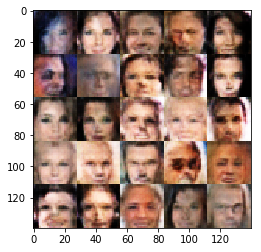

Epoch 0/1... Discriminator Loss: 1.0167... Generator Loss: 1.4335
Epoch 0/1... Discriminator Loss: 0.9613... Generator Loss: 0.8997
Epoch 0/1... Discriminator Loss: 1.1341... Generator Loss: 0.7528
Epoch 0/1... Discriminator Loss: 0.8852... Generator Loss: 1.2035
Epoch 0/1... Discriminator Loss: 0.8415... Generator Loss: 1.8630
Epoch 0/1... Discriminator Loss: 1.1399... Generator Loss: 0.8177
Epoch 0/1... Discriminator Loss: 0.9713... Generator Loss: 0.9151
Epoch 0/1... Discriminator Loss: 0.8491... Generator Loss: 1.1323
Epoch 0/1... Discriminator Loss: 0.9332... Generator Loss: 0.8952
Epoch 0/1... Discriminator Loss: 1.0281... Generator Loss: 1.0410
After run count 2900


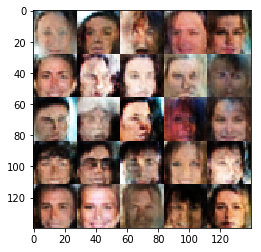

Epoch 0/1... Discriminator Loss: 1.2309... Generator Loss: 0.5743
Epoch 0/1... Discriminator Loss: 0.9685... Generator Loss: 1.0272
Epoch 0/1... Discriminator Loss: 1.1254... Generator Loss: 0.6121
Epoch 0/1... Discriminator Loss: 1.0307... Generator Loss: 1.0045
Epoch 0/1... Discriminator Loss: 0.9547... Generator Loss: 1.1807
Epoch 0/1... Discriminator Loss: 0.8346... Generator Loss: 1.0179
Epoch 0/1... Discriminator Loss: 1.3492... Generator Loss: 0.4458
Epoch 0/1... Discriminator Loss: 1.0072... Generator Loss: 0.7559
Epoch 0/1... Discriminator Loss: 0.9778... Generator Loss: 0.9010
Epoch 0/1... Discriminator Loss: 0.9465... Generator Loss: 1.0055
After run count 3000


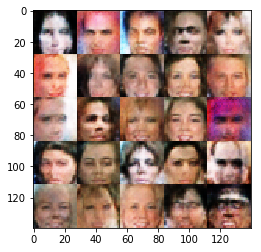

Epoch 0/1... Discriminator Loss: 0.8503... Generator Loss: 1.2808
Epoch 0/1... Discriminator Loss: 1.0893... Generator Loss: 0.8610
Epoch 0/1... Discriminator Loss: 1.4091... Generator Loss: 0.4162
Epoch 0/1... Discriminator Loss: 1.1447... Generator Loss: 0.6699
Epoch 0/1... Discriminator Loss: 1.0054... Generator Loss: 0.8399
Epoch 0/1... Discriminator Loss: 0.9051... Generator Loss: 1.0343
Epoch 0/1... Discriminator Loss: 0.8923... Generator Loss: 1.4166
Epoch 0/1... Discriminator Loss: 0.9556... Generator Loss: 1.1029
Epoch 0/1... Discriminator Loss: 0.9341... Generator Loss: 0.7364
Epoch 0/1... Discriminator Loss: 0.9119... Generator Loss: 1.0425
After run count 3100


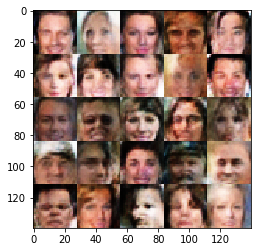

Epoch 0/1... Discriminator Loss: 0.8508... Generator Loss: 1.1909
Epoch 0/1... Discriminator Loss: 0.9942... Generator Loss: 0.7401
Epoch 0/1... Discriminator Loss: 0.7745... Generator Loss: 1.0039
Epoch 0/1... Discriminator Loss: 1.0500... Generator Loss: 0.7238
Epoch 0/1... Discriminator Loss: 1.1017... Generator Loss: 0.6444
Epoch 0/1... Discriminator Loss: 0.9156... Generator Loss: 1.1095


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [ ]:
print('done')